In [3]:
#Predict ICU LOS (hours)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

In [12]:
# -------------------------
# 0) Paths & safety checks
# -------------------------
base_path = r"" 
RESULTS_DIR = Path("results")
MODELS_DIR = Path("models")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

#Load Files
#File paths 
paths = { 'admissions': os.path.join(base_path, 'hosp', 'admissions.csv.gz'), 
          'patients': os.path.join(base_path, 'hosp', 'patients.csv.gz'), 
          'icustays': os.path.join(base_path, 'icu', 'icustays.csv.gz') }

# Load data print("Loading data...") 
admissions = pd.read_csv(paths['admissions'], parse_dates=['admittime', 'dischtime']) 
patients = pd.read_csv(paths['patients']) 
icustays = pd.read_csv(paths['icustays'], parse_dates=['intime', 'outtime'])

In [14]:
# Compute los_hours
icustays['los_hours'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds() / 3600.0

In [15]:
# Merge
df = icustays.merge(admissions, on='hadm_id', how='left', suffixes=('', '_adm')).merge(patients, on='subject_id', how='left')

In [16]:
df['admit_age'] = df.get('admit_age', df.get('anchor_age', np.nan)).astype(float)
df = df[(df['admit_age'] >= 18) & (df['admit_age'] <= 120)].copy()

In [17]:
# -------------------------
# 2) Feature engineering
# -------------------------
# Extract simple temporal features
df['intime_hour'] = df['intime'].dt.hour
df['intime_weekday'] = df['intime'].dt.weekday
df['admit_year'] = df['intime'].dt.year

# Age groups
df['age_group'] = pd.cut(df['admit_age'], bins=[18,30,50,70,120], labels=['18-30','31-50','51-70','71+'])

# Target cleaning: drop negative or null LOS
df = df[df['los_hours'].notnull() & (df['los_hours'] >= 0)]

# Optional: log-transform target to stabilize noise (toggle later)
df['los_hours_log'] = np.log1p(df['los_hours'])

# -------------------------
# 3) Select features
# -------------------------
# Start with a sensible, small set (expand later by adding labs/vitals/comorbidities)
categorical = ['gender', 'admission_type', 'ethnicity', 'insurance', 'age_group']
numeric = ['admit_age', 'intime_hour', 'intime_weekday', 'admit_year']
# Keep only columns present
categorical = [c for c in categorical if c in df.columns]
numeric = [c for c in numeric if c in df.columns]

FEATURES = numeric + categorical
TARGET_REG = 'los_hours'
TARGET_REG_LOG = 'los_hours_log'  # optional

print(f"Using features: {FEATURES}")
print(f"Target: {TARGET_REG}")

Using features: ['admit_age', 'intime_hour', 'intime_weekday', 'admit_year', 'gender', 'admission_type', 'insurance', 'age_group']
Target: los_hours


In [20]:
# -------------------------
# 4) Train-test split
# -------------------------
from sklearn.model_selection import train_test_split
X = df[FEATURES].copy()
y = df[TARGET_REG].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (75555, 8), Test size: (18889, 8)


In [23]:
# -------------------------
# 5) Preprocessing + Pipeline
# -------------------------

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, numeric),
    ('cat', cat_pipe, categorical)
])


In [29]:
# -------------------------
# 6) Baseline and tree models
# -------------------------
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, model, X_test, y_test, preds=None):
    if preds is None:
        preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))  # <-- fixed
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
    return {'name': name, 'rmse': rmse, 'mae': mae, 'r2': r2}

results = []

In [30]:
from xgboost import XGBRegressor
from sklearn.svm import SVR

# 6a) Linear Regression baseline
pipe_lr = Pipeline([('pre', preprocessor), ('lr', LinearRegression())])
pipe_lr.fit(X_train, y_train)
results.append(evaluate_model("LinearRegression", pipe_lr, X_test, y_test))

LinearRegression → RMSE: 127.36, MAE: 69.96, R²: 0.009


In [31]:
# 6b) Random Forest
pipe_rf = Pipeline([('pre', preprocessor), ('rf', RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1))])
pipe_rf.fit(X_train, y_train)
results.append(evaluate_model("RandomForest", pipe_rf, X_test, y_test))

RandomForest → RMSE: 135.03, MAE: 79.20, R²: -0.114


In [32]:
# 6c) HistGradientBoosting (fast, handles missingness well)
pipe_hgb = Pipeline([('pre', preprocessor), ('hgb', HistGradientBoostingRegressor(random_state=RANDOM_STATE))])
pipe_hgb.fit(X_train, y_train)
results.append(evaluate_model("HistGradientBoosting", pipe_hgb, X_test, y_test))

HistGradientBoosting → RMSE: 127.34, MAE: 69.85, R²: 0.010


In [33]:
# 6d) XGBoost Regressor
pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('xgb', XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])
pipe_xgb.fit(X_train, y_train)
results.append(evaluate_model("XGBoost", pipe_xgb, X_test, y_test))

XGBoost → RMSE: 127.91, MAE: 70.21, R²: 0.001


In [34]:
# 6e) Support Vector Regressor
pipe_svr = Pipeline([
    ('pre', preprocessor),
    ('svr', SVR(kernel='rbf', C=100, epsilon=0.2))
])
pipe_svr.fit(X_train, y_train)
results.append(evaluate_model("SVR", pipe_svr, X_test, y_test))

SVR → RMSE: 132.98, MAE: 58.94, R²: -0.080


In [35]:
# Save full summary
pd.DataFrame(results).to_csv(RESULTS_DIR / "model_summary.csv", index=False)

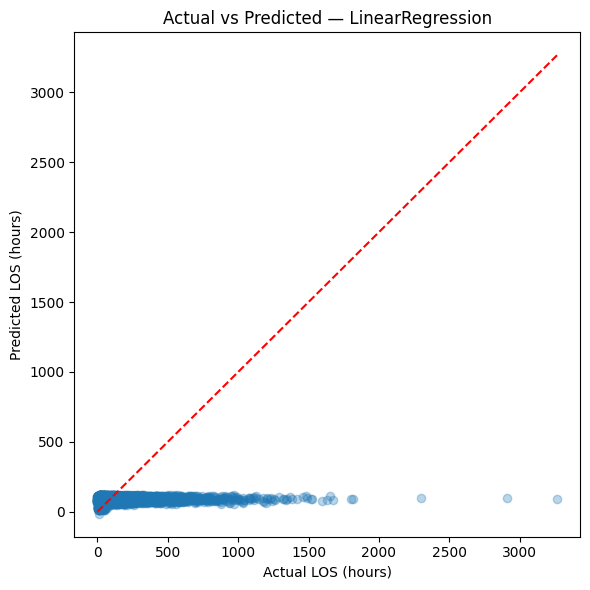

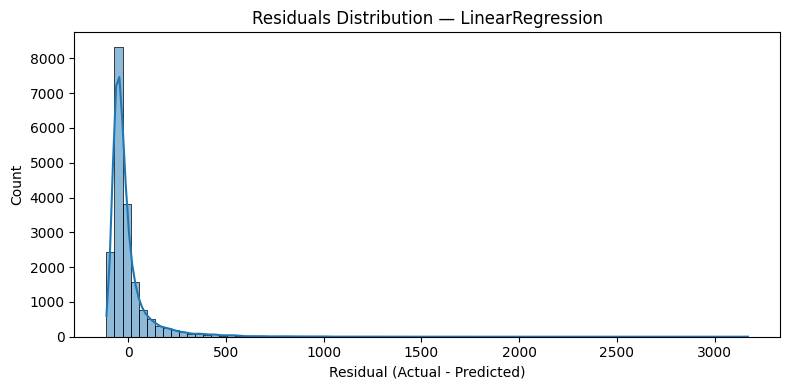

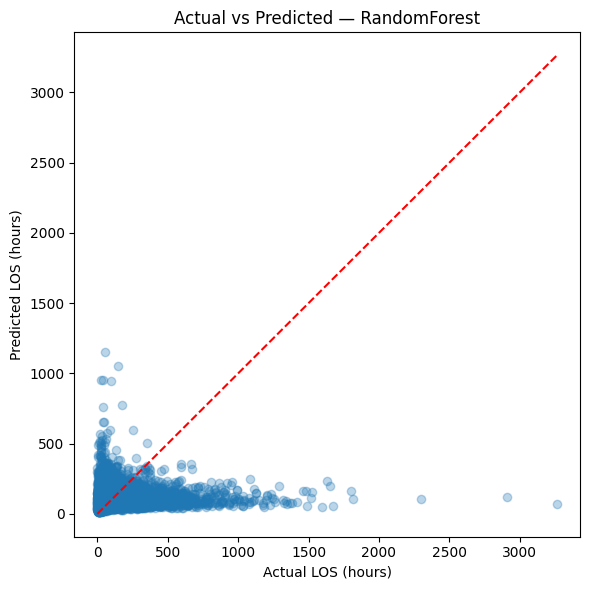

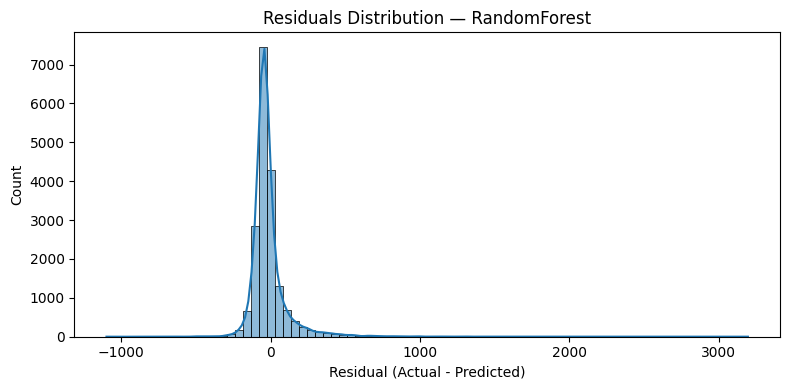

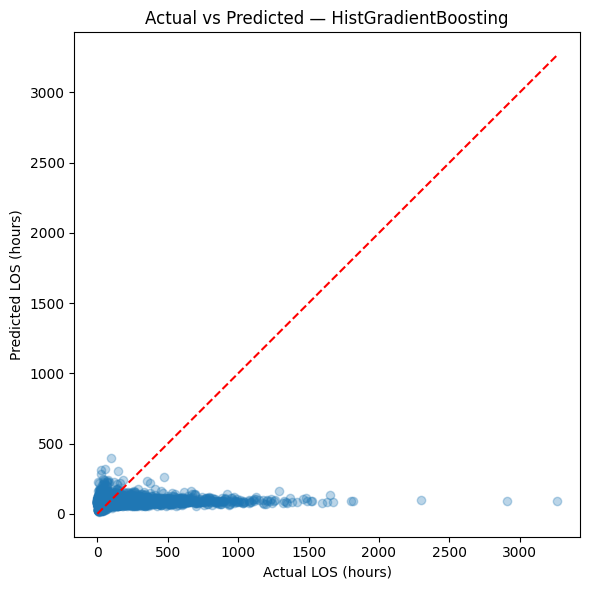

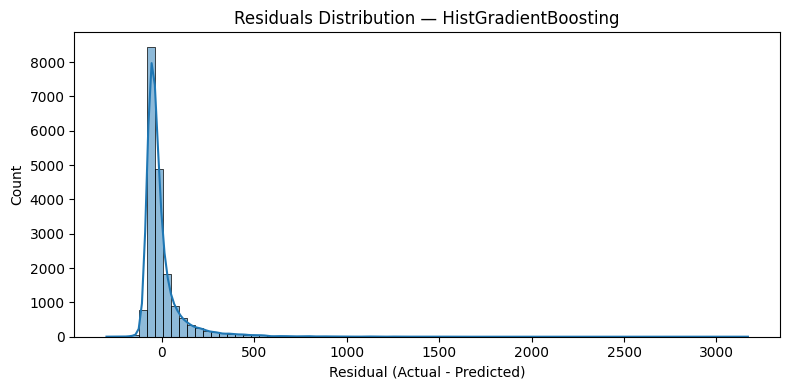

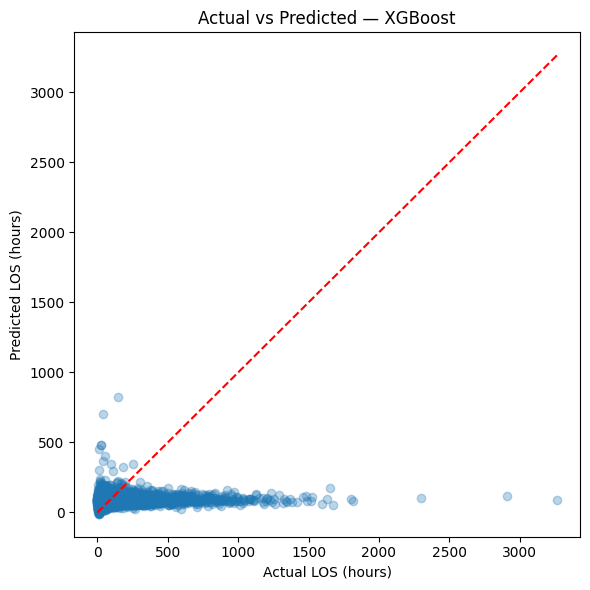

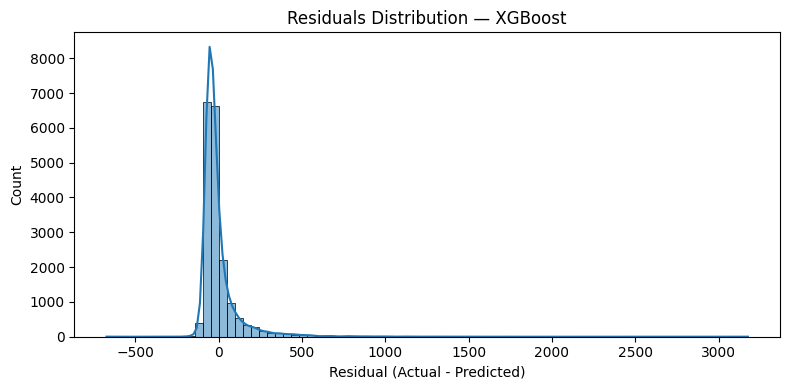

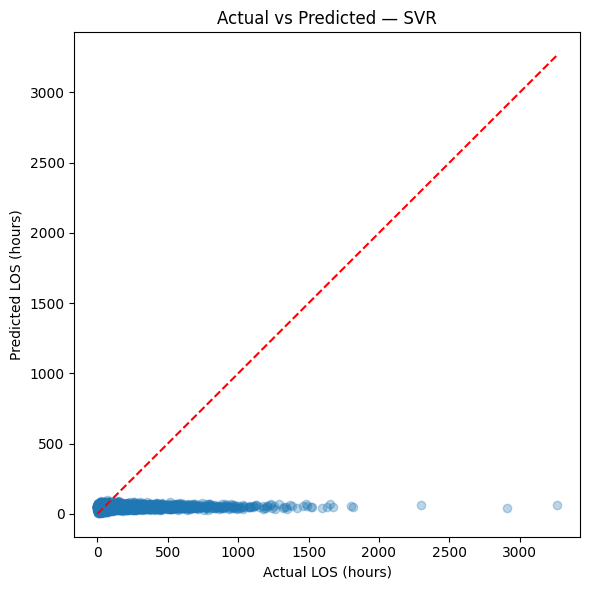

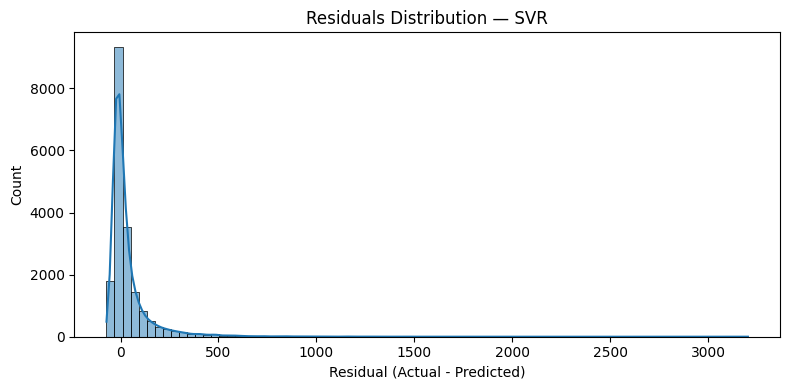

In [36]:
# -------------------------
# 8) Visualizations & Evaluation for all models
# -------------------------
import joblib

# Map model names to pipelines
name_to_pipe = {
    "LinearRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "HistGradientBoosting": pipe_hgb,
    "XGBoost": pipe_xgb,
    "SVR": pipe_svr
}

for model_info in results:
    name = model_info['name']
    pipe = name_to_pipe.get(name)
    if pipe is None:
        continue

    # Predictions
    preds = pipe.predict(X_test)

    # Actual vs Predicted
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, preds, alpha=0.3)
    plt.plot([0, max(y_test.max(), preds.max())], [0, max(y_test.max(), preds.max())], 'r--')
    plt.xlabel("Actual LOS (hours)")
    plt.ylabel("Predicted LOS (hours)")
    plt.title(f"Actual vs Predicted — {name}")
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"actual_vs_pred_{name}.png")
    plt.show()

    # Residuals
    residuals = y_test - preds
    plt.figure(figsize=(8,4))
    sns.histplot(residuals, bins=80, kde=True)
    plt.title(f"Residuals Distribution — {name}")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"residuals_distribution_{name}.png")
    plt.show()


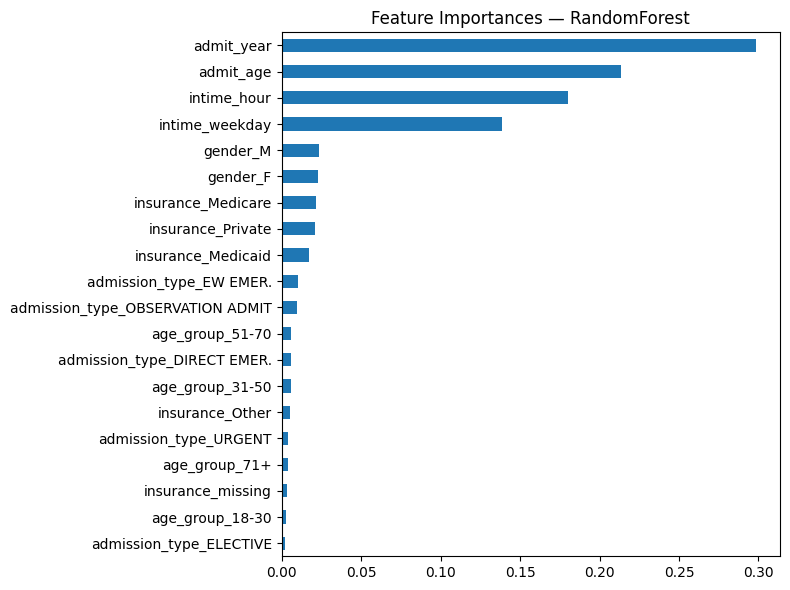

HistGradientBoosting does not expose feature_importances_.


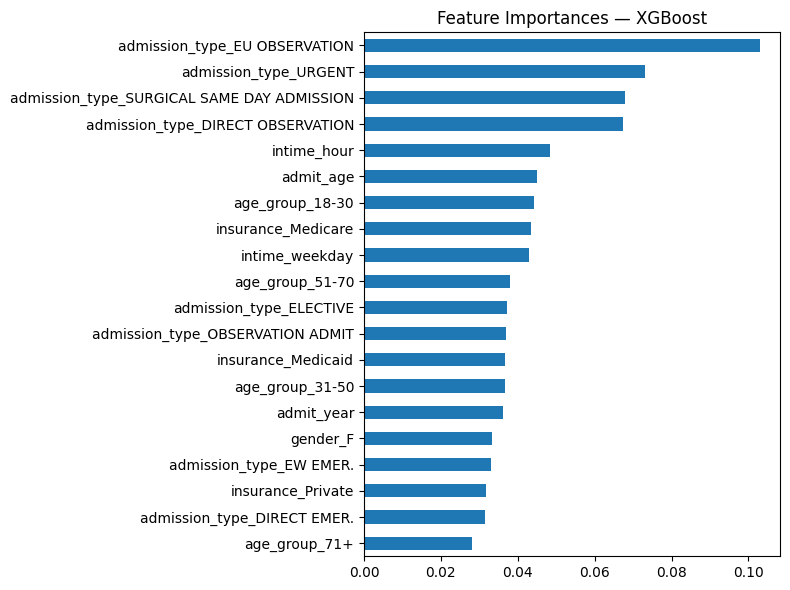

In [39]:
# -------------------------
# 9) Feature importance (for tree models)
# -------------------------
# For RandomForest or HGB, get importances (requires retrieving column names after preprocessing)
# Build a small helper to get preprocessor output feature names
tree_models = ["RandomForest", "HistGradientBoosting", "XGBoost"]

for name in tree_models:
    pipe = name_to_pipe.get(name)
    if pipe is None:
        continue
    try:
        preprocessor_fitted = pipe.named_steps['pre']
        # Get numeric + OHE categorical feature names
        num_names = numeric
        cat_ohe = preprocessor_fitted.named_transformers_['cat'].named_steps['oh']
        cat_names = list(cat_ohe.get_feature_names_out(categorical))
        feat_names = num_names + cat_names
        
        estimator = pipe.named_steps[list(pipe.named_steps.keys())[-1]]
        if hasattr(estimator, "feature_importances_"):
            fi = pd.Series(estimator.feature_importances_, index=feat_names).sort_values(ascending=False)
            fi.head(30).to_csv(RESULTS_DIR / f"feature_importances_{name}.csv")
            plt.figure(figsize=(8,6))
            fi.head(20).plot(kind='barh')
            plt.gca().invert_yaxis()
            plt.title(f"Feature Importances — {name}")
            plt.tight_layout()
            plt.savefig(RESULTS_DIR / f"feature_importances_{name}.png")
            plt.show()
        else:
            print(f"{name} does not expose feature_importances_.")
    except Exception as e:
        print(f"Could not compute feature importances for {name}: {e}")


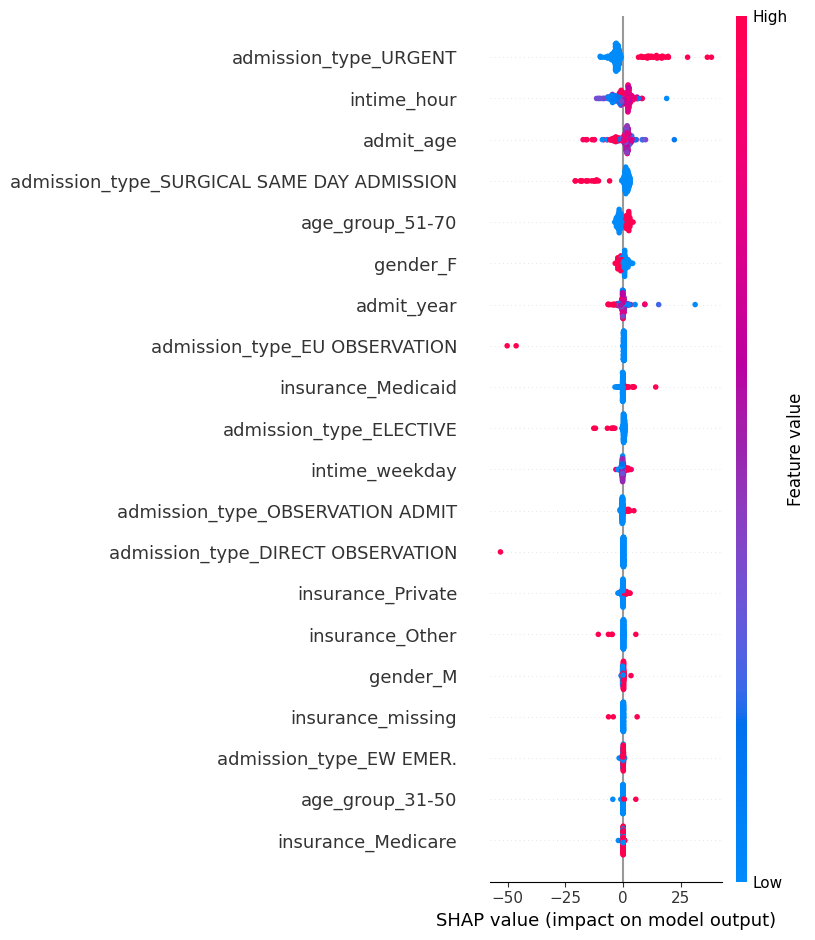

In [42]:
# For HGB

import shap

preprocessor_fitted = pipe_hgb.named_steps['pre']
estimator = pipe_hgb.named_steps['hgb']

# Transform test set
X_test_pre = preprocessor_fitted.transform(X_test)

# Create SHAP explainer
explainer = shap.Explainer(estimator)
shap_values = explainer(X_test_pre[:200])

# Plot SHAP summary
feat_names = numeric + list(preprocessor_fitted.named_transformers_['cat'].named_steps['oh'].get_feature_names_out(categorical))
shap.summary_plot(shap_values, features=X_test_pre[:200], feature_names=feat_names, show=True)


In [43]:
# -------------------------
# 10) Save all models
# -------------------------
for name, pipe in name_to_pipe.items():
    joblib.dump(pipe, MODELS_DIR / f"{name}_pipeline.joblib")
print("All models saved to", MODELS_DIR)

All models saved to models


In [45]:
# -------------------------
# 10) SHAP explainability for tree-based models
# -------------------------

def get_feature_names(preprocessor):
    # Numeric features
    num_names = numeric
    # One-hot encoded categorical features
    cat_ohe = preprocessor.named_transformers_['cat'].named_steps['oh']
    cat_names = list(cat_ohe.get_feature_names_out(categorical))
    return num_names + cat_names

try:
    import shap
    for name in tree_models:
        pipe = name_to_pipe.get(name)
        if pipe is None:
            continue
        preprocessor_fitted = pipe.named_steps['pre']
        estimator = pipe.named_steps[list(pipe.named_steps.keys())[-1]]
        X_test_pre = preprocessor_fitted.transform(X_test)
        explainer = shap.Explainer(estimator)
        shap_values = explainer(X_test_pre[:200])
        shap.summary_plot(shap_values, features=X_test_pre[:200],
                          feature_names=get_feature_names(preprocessor_fitted), show=False)
        plt.savefig(RESULTS_DIR / f"shap_summary_{name}.png", bbox_inches='tight')
        plt.close()
except Exception as e:
    print("SHAP not run (install shap or error):", e)